In [1]:
from manifoldpy.manifoldpy import api, cache_utils
from manifoldpy.manifoldpy.api import Market
from manifoldpy.manifoldpy import config, calibration
from pprint import pprint
import json
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import openai

with open("/Users/jasper/oai.txt", "r") as f:
    openai.api_key = f.read().strip()

with open('api_key.txt', 'r') as f:
    api_key = f.read().strip()

markets_json_path = "manifold-dump-markets-04082023.json"

In [ ]:
cache_utils.update_lite_markets()
cache_utils.backfill_bets()

In [12]:
cache_utils.save_cache(cache_utils.load_cache())

In [2]:
full_markets = cache_utils.load_full_markets()
binary = [
    m for m in full_markets if isinstance(m, api.BinaryMarket) and len(m.bets) > 0 and m.resolution != 'CANCEL'
]

In [3]:
from time_utils import get_price_at_timestamp, get_price

def run_experiment(hours: int = 24, pHigh: float = 0.18, pLow: float = 0.05, minVolume: int = 50, since: datetime = None):
    deltas = []
    for bin_market in binary:
        if since is not None and bin_market.createdTime < since.timestamp() * 1000:
            continue
        # parse createdTime (Unix epoch timestamp in ms) to datetime
        created_datetime = datetime.fromtimestamp(bin_market.createdTime / 1000)
        one_day_after = created_datetime + timedelta(hours=hours)
        one_day_after_timestamp = one_day_after.timestamp()
        one_day_after_timestamp_ms = one_day_after_timestamp * 1000
        # initial_price = get_price_at_timestamp(bin_market, bin_market.createdTime)
        price_at_one_day_after = get_price_at_timestamp(bin_market, one_day_after_timestamp_ms)
        
        if price_at_one_day_after < pHigh and price_at_one_day_after > pLow:
            current_price = get_price_at_timestamp(bin_market, datetime.now().timestamp() * 1000)
            deltas.append(current_price - price_at_one_day_after)

    if len(deltas) == 0:
        return None, None
    return sum(deltas) / len(deltas), len(deltas)

In [ ]:

highestsofar = 0
highest_metadata = ""
lowestsofar = 0
lowest_metadata = ""

deltas_df = pd.DataFrame(columns=['Hours', 'pHigh', 'pLow', 'avg_delta', 'sample_size', 'cutoff_date'])
all_deltas = []

for i in [6]: # hours since market creation
    print(f"Hours: {i}")
    for j in tqdm(range(1, 99, 3)): # pHigh
        for k in range(1, 99, 3): # pLow
            for date_cutoff in [None, datetime(2021, 8, 1), datetime(2022, 8, 1), datetime(2023, 3, 1)]:
                if j <= k:
                    continue
                avg_delta, sample_size = run_experiment(
                    hours=i,
                    pHigh=j/100,
                    pLow=k/100,
                    since=date_cutoff
                )
                # print(f"Hours: {i}, pHigh: {j}, pLow: {k}, avg_delta: {avg_delta}, sample_size: {sample_size}")
                if avg_delta is None:
                    continue

                all_deltas.append({
                    'Hours': i,
                    'pHigh': j/100,
                    'pLow': k/100,
                    'avg_delta': avg_delta,
                    'sample_size': sample_size,
                    'cutoff_date': date_cutoff
                })

deltas_df = pd.concat([deltas_df, pd.DataFrame(all_deltas)])

In [24]:
# get the maximum of avg_delta where sample_size >= 1000
deltas_df[deltas_df['sample_size'] >= 1000].sort_values(by='avg_delta', ascending=True).head(10)

,Hours,pHigh,pLow,avg_delta,sample_size,cutoff_date
995,6,0.67,0.52,-0.027951,1021,2023-03-01
1083,6,0.70,0.52,-0.026828,1172,2023-03-01
991,6,0.67,0.49,-0.026807,1267,2023-03-01
1587,6,0.85,0.55,-0.026416,1595,2023-03-01
1591,6,0.85,0.58,-0.026267,1432,2023-03-01
1583,6,0.85,0.52,-0.026265,1829,2023-03-01
907,6,0.64,0.49,-0.026252,1085,2023-03-01
1079,6,0.70,0.49,-0.026001,1418,2023-03-01
1699,6,0.88,0.55,-0.025888,1713,2023-03-01
1695,6,0.88,0.52,-0.025810,1947,2023-03-01


In [7]:
# analyze specific strategies
        
from strategy import Strategy

class Permabear(Strategy):
    def __init__(self, hi: float, lo: float):
        super().__init__("Permabear")
        self.hi = hi
        self.lo = lo

    def strategy(self, market: Market):
        position = 'NO'

        created_datetime = datetime.fromtimestamp(market.createdTime / 1000)
        one_day_after = created_datetime + timedelta(hours=6)
        one_day_after_timestamp = one_day_after.timestamp()
        one_day_after_timestamp_ms = one_day_after_timestamp * 1000

        price_at_one_day_after = get_price_at_timestamp(market, one_day_after_timestamp_ms)
        current_price = get_price_at_timestamp(market, datetime.now().timestamp() * 1000)

        if not (price_at_one_day_after < self.hi and price_at_one_day_after > self.lo):
            return None, None
    
        delta = self.evaluate_strategy(price_at_one_day_after, current_price, position)
        return delta, position

    def __str__(self):
        return f"Permabear({self.hi}, {self.lo})"

class Midwit(Strategy):
    def __init__(self):
        super().__init__("Midwit")

    def strategy(self, market: Market):
        created_datetime = datetime.fromtimestamp(market.createdTime / 1000)
        one_day_after = created_datetime + timedelta(hours=6)
        one_day_after_timestamp = one_day_after.timestamp()
        one_day_after_timestamp_ms = one_day_after_timestamp * 1000

        price_at_one_day_after = get_price_at_timestamp(market, one_day_after_timestamp_ms)
        current_price = get_price_at_timestamp(market, datetime.now().timestamp() * 1000)

        if current_price - price_at_one_day_after == 0:
            return None, None

        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0613",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": "Determine whether this market will resolve to YES or NO using your best judgement:" + market.question},
            ],
            functions=[
                {
                    "name": "yes_or_no",
                    "description": "Returns either YES or NO",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "yes_or_no": {"type": "string", "enum": ["YES", "NO"]},
                        },
                        "required": ["yes_or_no"],
                    },
                }
            ],
            function_call={"name": "yes_or_no"}
        )

        # print(completion.choices[0])
        json_resp = completion.choices[0]['message']['function_call']['arguments']
        position = json.loads(json_resp)['yes_or_no']
        print(market.question, position)

        if position not in ['YES', 'NO']:
            return None, None

        delta = self.evaluate_strategy(price_at_one_day_after, current_price, position)
        return delta, position
    
# test the strategies against the data

strategies = [
    Permabear(0.66, 0.53),
    # Midwit()
]

for strategy in strategies:
    print(f"Running strategy: {strategy}")
    deltas = strategy.run(binary, since=datetime(2023, 7, 1))
    print(f"Average delta: {sum(deltas) / len(deltas)}")
    print(f"Sample size: {len(deltas)}")
    print()

Running strategy: Permabear(0.66, 0.53)
Average delta: 0.0343133038952351
Sample size: 591

Running strategy: Permabear(0.73, 0.5)
Average delta: 0.02936714098826517
Sample size: 989



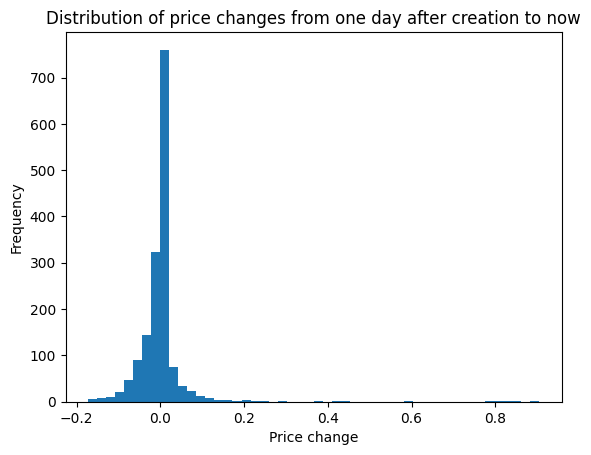

-0.0012241569521753808
1586


In [41]:
# make a histogram of the deltas
import matplotlib.pyplot as plt

plt.hist(deltas, bins=50)
plt.title("Distribution of price changes from one day after creation to now")
plt.xlabel("Price change")
plt.ylabel("Frequency")
plt.show()